In [1]:
import sys
# Append system path
sys.path = [p for p in sys.path if not p.endswith("../..")]  # Cleans duplicated '../.."
sys.path.insert(0, "../")  # This adds `src` to the path

import os
import logging

import pandas as pd
import numpy as np

from helpers import io
from analysis import multimodal_util

logging.basicConfig(level=logging.INFO, handlers=[logging.StreamHandler(stream=sys.stdout)])

pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Prep the data

In [2]:
# Whether and where to output plots
PLOT_TOFILE = True
PLOT_DIR = "~/dpi-plotsmultimodal/"
PLOT_PPI = 300
MAX_LABELLIMIT = 400 # Large number to avoid label summarization in plots

PLOT_DIR = os.path.expanduser(PLOT_DIR)

# Create directory if needed
if PLOT_TOFILE:
    os.makedirs(PLOT_DIR, exist_ok=True)

# Plotting constants
LICENSE_ORDER = ["NC/Acad", "Unspecified", "Commercial"]
LICENSE_PALETTE = ["#e04c71", "#e0cd92", "#82b5cf"]
LICENSE_TERMS_ORDER = [
    "NC/Acad | Model Closed", "NC/Acad | Source Closed", "NC/Acad | Unspecified", "NC/Acad | Unrestricted",
    "Unspecified | Model Closed", "Unspecified | Source Closed", "Unspecified | Unspecified", "Unspecified | Unrestricted",
    "Commercial | Model Closed", "Commercial | Source Closed", "Commercial | Unspecified", "Commercial | Unrestricted",
]
LICENSE_TERMS_ORDER_VARIANT = [
    "NC/Acad | Restricted", "NC/Acad | Unspecified", "NC/Acad | Unrestricted",
    "Unspecified | Restricted", "Unspecified | Unspecified", "Unspecified | Unrestricted",
    "Commercial | Restricted", "Commercial | Unspecified", "Commercial | Unrestricted"
]
LICENSE_TERMS_PALETTE = [
    '#9d354f', '#c24262', '#e04c71',
    '#9d9066', '#c2b27f', '#e0cd92',
    '#5b7f91', '#719db3', '#82b5cf',
]

LICENSE_PLOTW = 400
LICENSE_PLOTH = 100
YEAR_CATEGORIES = ["Unknown", "<2013", *list(map(str, range(2013, 2025)))]

# Read constants
all_constants = io.read_all_constants("../../constants/")

# Read Terms data
collection_to_terms_mapper = multimodal_util.load_terms_metadata("data/multimodal_terms_data")

# Read individual modality summaries
text_summaries = io.read_data_summary_json("../../data_summaries/")
logging.info("Checking Text Data Summaries against Constants")
# analysis_util.check_datasummary_in_constants(text_summaries, all_constants)

speech_summaries = io.read_data_summary_json("../../data_summaries-speech/")
logging.info("Checking Speech Data Summaries against Constants")
# analysis_util.check_datasummary_in_constants(speech_summaries, all_constants)

video_summaries = io.read_data_summary_json("../../data_summaries-video/")
logging.info("Checking Video Data Summaries against Constants")
# analysis_util.check_datasummary_in_constants(video_summaries, all_constants)


INFO:root:Checking Text Data Summaries against Constants
INFO:root:Checking Speech Data Summaries against Constants
INFO:root:Checking Video Data Summaries against Constants


In [3]:
def modality_task_annotation(df, modality, task_col, dset_col):
    TASK_TYPEMAP = multimodal_util.invert_dict_of_lists(all_constants["TASK_GROUPS"])
    TASKCATEGORY_ORDER = sorted(set(TASK_TYPEMAP.values()) - {"null"})
    df_speech = df[df['Modality'] == modality]
        # Categorize the tasks into their respective groups
    df_speech_tasks = multimodal_util.categorize_tasks(
        df_speech, TASKCATEGORY_ORDER, TASK_TYPEMAP, task_col, modality, dset_col, False)
    df_speech_tasks = df_speech_tasks[['Unique Dataset Identifier', task_col]]
    df_speech_tasks = df_speech_tasks.rename(columns={task_col: 'Task Groups'})
    df_speech_tasks_grouped = df_speech_tasks.groupby('Unique Dataset Identifier')['Task Groups'].apply(list).reset_index()
    df_speech = pd.merge(df_speech, df_speech_tasks_grouped, on='Unique Dataset Identifier', how='inner')
    return df_speech

def get_terms_licenses(df):
    LICENSE_TERMS_MODALITY_ORDER_2 = ["Text (Collections)", "Text (Datasets)", "Speech", "Video"]
    
    dflt = multimodal_util.plot_license_terms_stacked_bar_chart_collections(
        df, "License | Terms", LICENSE_TERMS_PALETTE, LICENSE_TERMS_ORDER_VARIANT,
        LICENSE_TERMS_MODALITY_ORDER_2, 800, 140,
        # save_dir=PLOT_DIR,  # svg saving package compatibility issues, and you can save from the notebook anyway
        plot_ppi=PLOT_PPI,
        title="Dataset & Source Restrictions (Dataset Count)",
        no_legend=True,
        split_text_mod=False,
        return_df=True,
        early_return=True,
    )
    dflt[['Dataset License', 'Collection Terms']] = dflt['License | Terms'].str.split('|', expand=True)
    dflt['Dataset License'] = dflt['Dataset License'].str.strip()
    dflt['Collection Terms'] = dflt['Collection Terms'].str.strip()
    dflt = dflt[["Unique Dataset Identifier", 'Dataset License', 'Collection Terms']]
    return dflt

def get_creators_info(df):
    df_countries = df.explode("Countries").dropna(subset=["Countries"])  # Drop rows with no country for the moment
    df_countries["Creator Country ID"] = df_countries["Countries"].map(multimodal_util.get_country)
    df_countries_grouped = df_countries.groupby('Unique Dataset Identifier')['Creator Country ID'].apply(lambda x: [item for sublist in x for item in sublist]).reset_index()
    df2 = pd.merge(df, df_countries_grouped, on='Unique Dataset Identifier', how='outer')
    df2 = df2.rename(columns={"Countries": 'Creator Countries'})
    return df2

def get_langs_info(df):
    _, df_text_lang_explode = multimodal_util.prep_text_for_lang_gini(df, all_constants)
    df_text_lang_groups = df_text_lang_explode.groupby('Unique Dataset Identifier')['Language (ISO)'].apply(list).reset_index()
    df_text_lang_groups2 = df_text_lang_explode.groupby('Unique Dataset Identifier')['Language Family'].apply(list).reset_index()
    df_text_lang_combined = pd.merge(df_text_lang_groups, df_text_lang_groups2, on='Unique Dataset Identifier', how='outer')
    _, df_speechlanguagesn = multimodal_util.prepare_speech_for_gini(df)
    df_speech_lang_groups = df_speechlanguagesn.groupby('Unique Dataset Identifier')['Language (ISO)'].apply(list).reset_index()
    df_speech_lang_groups2 = df_speechlanguagesn.groupby('Unique Dataset Identifier')['Language Family'].apply(list).reset_index()
    df_speech_lang_combined = pd.merge(df_speech_lang_groups, df_speech_lang_groups2, on='Unique Dataset Identifier', how='outer')
    df_langs_combined = pd.concat([df_text_lang_combined, df_speech_lang_combined])
    return df_langs_combined

In [4]:
# Prep dataframes
df_all = multimodal_util.prep_summaries_for_visualization(
    text_summaries,
    speech_summaries,
    video_summaries,
    all_constants,
    collection_to_terms_mapper,
    YEAR_CATEGORIES,
    LICENSE_ORDER,
)

In [5]:
df_speech = modality_task_annotation(df_all, "Speech", "Tasks", "Datasets")
df_video = modality_task_annotation(df_all, "Video", "Task Categories", "Datasets")
df_text = modality_task_annotation(df_all, "Text", "Task Categories", "Collections")
df_w_tasks = pd.concat([df_text, df_speech, df_video])

df_w_creators = get_creators_info(df_all)

df_w_langs = get_langs_info(df_all)

df_w_licterms = get_terms_licenses(df_all)

df_merged = pd.merge(df_all, df_w_tasks, on='Unique Dataset Identifier', how='outer')
df_merged = pd.merge(df_merged, df_w_creators, on='Unique Dataset Identifier', how='outer')
df_merged = pd.merge(df_merged, df_w_langs, on='Unique Dataset Identifier', how='outer')
df_merged = pd.merge(df_merged, df_w_licterms, on='Unique Dataset Identifier', how='outer')

/u/wbrannon/github/Data-Provenance-Collection/src/analysis/../analysis/multimodal_util.py:2549: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_spec_cum = df_spec.groupby(
/u/wbrannon/github/Data-Provenance-Collection/src/analysis/../analysis/multimodal_util.py:2557: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_spec_cum_gini = df_spec_cum.groupby("Year Released Category")[
/u/wbrannon/github/Data-Provenance-Collection/src/analysis/../analysis/multimodal_util.py:2549: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False t

In [6]:
df = df_merged[[
    'Unique Dataset Identifier',
    'Dataset Name',
    # 'Paper Title',
     #'Dataset URL',
    # 'GitHub URL',
    # 'Hugging Face URL',
    # 'Papers with Code URL',
    # 'ArXiv URL',
    # 'Semantic Scholar Corpus ID',
    'Collection',
     #'Collection URL',
    'Text Sources',
    'Model Generated',
    'Human Annotation',
    'Derived from Datasets',
    'Creators',
    # 'Licenses',
    # 'Bibtex',
    'Inferred Metadata',
    'Text Metrics',
    # 'GitHub License',
    # 'HF Yaml License',
    # 'HF Config License',
    # 'PwC License',
    # 'License Use (DataProvenance)',
    # 'License Attribution (DataProvenance)',
    # 'License Share Alike (DataProvenance)',
    'Modality',
    'Total Tokens',
    'Year Released',
    # 'Hours',
    # 'Speakers',
    'Source Category',
    # 'Paper URL',
    # 'Website URL',
    'Language (ISO)',
    'Language Family',
    'Task Groups',
    'Dataset License',
    'Collection Terms',
    'Creator Countries',                  
]]

df['Model Generated'] = df['Model Generated'].apply(lambda y: np.nan if len(y)==0 else y)
df['Year Released'] = df['Year Released'].replace('Unknown', np.nan)
df['is_synthetic'] = df['Model Generated'].notna()

# df.to_csv("multimodal_df.csv", index=False)

df.shape

/tmp/ipykernel_3787714/491733313.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Model Generated'] = df['Model Generated'].apply(lambda y: np.nan if len(y)==0 else y)
/tmp/ipykernel_3787714/491733313.py:46: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Year Released'] = df['Year Released'].replace('Unknown', np.nan)
/tmp/ipykernel_3787714/491733313.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See 

(3932, 21)

In [7]:
df.head().T

,0,1,2,3,4
Unique Dataset Identifier,100doh,10k Prompt Ranked,1111-hours-hindi-asr-challenge,120h-spanish-speech,20BN-jester
Dataset Name,100DOH: Understanding Human Hands in Contact a...,10k Prompts Ranked,1111-hours-hindi-asr-challenge,120h-spanish-speech,20BN-jester: The Jester Dataset: A Large-Scale...
Collection,100doh,10k Prompt Ranked,1111 Hours Hindi ASR Challenge,120h Spanish Speech,20BN-jester
Text Sources,[youtube],"[sharegpt.com, crowdsourced, chat.lmsys.org, w...",NaN,NaN,[crowdsourced]
Model Generated,NaN,"[Nous-Hermes-2-Yi-34B, Mistral-7B-Instruct-v0....",NaN,NaN,NaN
Human Annotation,NaN,Yes,NaN,NaN,NaN
Derived from Datasets,NaN,[huggingface.co/datasets/ewof/sharegpt-instruc...,NaN,NaN,NaN
Creators,"[University of Michigan, Johns Hopkins Univers...","[Huggingface, Argilla]",[Gram Vaani],[Independent],[Twenty Billion Neurons GmbH]
Inferred Metadata,"{'GitHub License': 'MIT License', 'GitHub Star...","{'GitHub License': '', 'GitHub Stars (May 2024...","{'GitHub License': '', 'GitHub Stars (June 202...","{'GitHub License': '', 'GitHub Stars (June 202...","{'GitHub License': '', 'GitHub Stars (June 202..."
Text Metrics,NaN,"{'Num Dialogs': 10331, 'Mean Inputs Length': 1...",NaN,NaN,NaN


# Descriptive stats

## Distribution of datasets over time

In [8]:
df.groupby('Year Released').size()

Year Released
1990.000       1
1992.000       1
1994.000       1
2000.000       1
2002.000       2
2003.000       5
2004.000       6
2005.000       3
2007.000       5
2008.000       1
2009.000       4
2010.000       7
2011.000      11
2012.000      31
2013.000      13
2014.000      13
2015.000      63
2016.000      45
2017.000      51
2018.000      90
2019.000     406
2020.000     456
2021.000    1081
2022.000     628
2023.000     716
2024.000     105
dtype: int64

<Axes: xlabel='Year Released'>

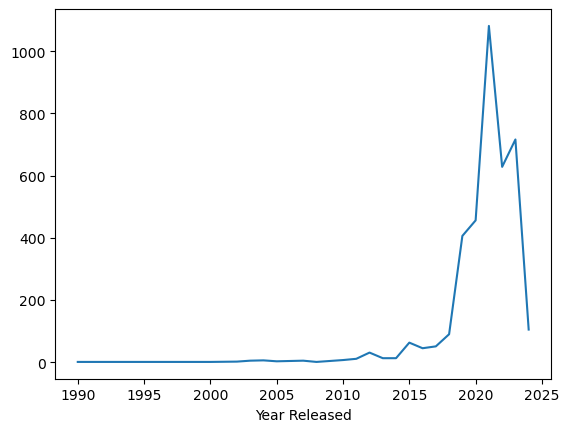

In [9]:
df.groupby('Year Released').size().plot()

array([<Axes: xlabel='Year Released'>, <Axes: xlabel='Year Released'>,
       <Axes: xlabel='Year Released'>], dtype=object)

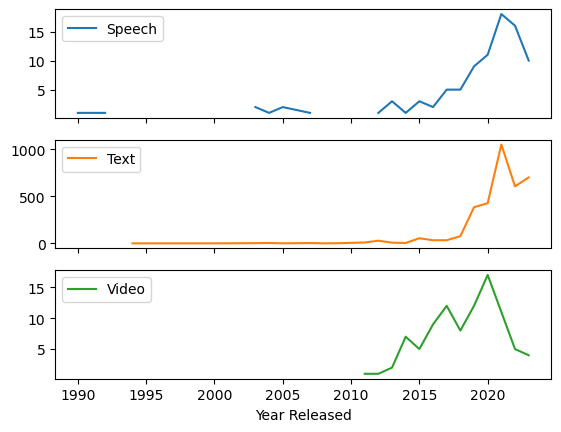

In [10]:
df.groupby(['Modality', 'Year Released']).size().unstack(0).drop([2024], axis=0).plot(subplots=True)

## Distribution of synthetic data

In [11]:
df['is_synthetic'].mean()

0.12538148524923703

In [12]:
df.groupby('Modality')['is_synthetic'].mean()

Modality
Speech   0.000
Text     0.132
Video    0.000
Name: is_synthetic, dtype: float64

# Focusing only on text

In [13]:
tmp = df.loc[df['Modality'] == 'Text'].drop('Modality', axis=1).copy()

tm_names = df['Text Metrics'].apply(lambda s: list(s.keys()) if not isinstance(s, float) else []).tolist()
tm_names = [y for x in tm_names for y in x]
tm_names = set(tm_names)

for name in tm_names:
    tmp[name] = tmp['Text Metrics'].apply(lambda s: s[name] if not isinstance(s, float) else np.nan)

im_names = df['Inferred Metadata'].apply(lambda s: list(s.keys()) if not isinstance(s, float) else []).tolist()
im_names = [y for x in im_names for y in x]
im_names = set(im_names)

for name in im_names:
    tmp[name] = tmp['Inferred Metadata'].apply(lambda s: s[name] if not isinstance(s, float) and name in s.keys() else np.nan)

tmp.drop(['Text Metrics', 'Inferred Metadata'], axis=1, inplace=True)

tmp['S2 Citation Count (May 2024)'] = tmp['S2 Citation Count (May 2024)'].replace('', np.nan)
tmp['HF Downloads (June 2024)'] = tmp['HF Downloads (June 2024)'].replace('', np.nan)

tmp['citations_per_year'] = (tmp['S2 Citation Count (May 2024)'] / (2024 - tmp['Year Released'])).replace(np.inf, np.nan)
tmp['downloads_per_year'] = tmp['HF Downloads (June 2024)'] / (2024 - tmp['Year Released']).replace(np.inf, np.nan)

tmp['Total Turns'] = tmp['Num Dialogs'] * tmp['Mean Dialog Turns']
tmp['Mean Turn Length'] = tmp['Total Tokens'] / tmp['Total Turns']

def english_status(s):
    if isinstance(s, float):
        return np.nan

    if len(s) == 1 and 'eng' in s:
        return 'english-only'

    if len(s) == 1:
        return 'non-english'

    return 'multilingual'

tmp['english_status'] = tmp['Language (ISO)'].apply(english_status)

/tmp/ipykernel_3787714/2490481326.py:19: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tmp['S2 Citation Count (May 2024)'] = tmp['S2 Citation Count (May 2024)'].replace('', np.nan)
/tmp/ipykernel_3787714/2490481326.py:20: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tmp['HF Downloads (June 2024)'] = tmp['HF Downloads (June 2024)'].replace('', np.nan)


## Size stats

In [14]:
tmp.groupby('is_synthetic').size()

is_synthetic
False    3239
True      493
dtype: int64

In [15]:
tmp.groupby('is_synthetic')['Total Tokens'].describe().T

is_synthetic,False,True
count,3223.000,424.000
mean,612847629.804,258495771.104
std,4417490032.906,1205606564.650
min,398.000,2396.000
25%,355576.000,665018.076
50%,1217648.000,9088187.838
75%,11587344.000,77660867.964
max,58136100000.000,18249124438.035


## Token-level stats

In [16]:
tmp['Total Tokens'].sum() / tmp['Total Turns'].sum()

1032.7442422442878

In [17]:
tmp.loc[tmp['is_synthetic'] == True, 'Total Turns'].mean()

256380.515903066

In [18]:
tmp.loc[tmp['is_synthetic'] == False, 'Total Turns'].mean()

592616.7179247285

In [19]:
tmp.loc[tmp['is_synthetic'] == True, 'Total Tokens'].sum() / tmp.loc[tmp['is_synthetic'] == True, 'Total Turns'].sum()

1008.250452238093

In [20]:
tmp.loc[tmp['is_synthetic'] == False, 'Total Tokens'].sum() / tmp.loc[tmp['is_synthetic'] == False, 'Total Turns'].sum()

1034.138273975741

In [21]:
tmp.groupby('is_synthetic')[[
    'Total Tokens',
    'Total Turns',
    'Mean Turn Length',
    'Min Targets Length',
    'Min Inputs Length',
    'Mean Targets Length',
    'Mean Inputs Length',
    'Max Targets Length',
    'Max Dialog Turns',
    'Max Inputs Length',
    'Num Dialogs',
    'Mean Dialog Turns',
    'Min Dialog Turns',
]].describe().T.unstack(0).T

count          mean            std  \
is_synthetic                                                             
False        Total Tokens        3223.000 612847629.804 4417490032.906   
             Total Turns         3223.000    592616.718    2404715.498   
             Mean Turn Length    3223.000      1065.586       2395.264   
             Min Targets Length  3223.000        46.948        152.070   
             Min Inputs Length   3223.000       254.762        559.907   
             Mean Targets Length 3223.000       299.064       1124.008   
             Mean Inputs Length  3223.000       766.521       2025.147   
             Max Targets Length  3223.000      3306.591      66846.051   
             Max Dialog Turns    3223.000        12.664        267.718   
             Max Inputs Length   3223.000      5758.212      83345.004   
             Num Dialogs         3223.000    283350.501    1058682.812   
             Mean Dialog Turns   3223.000         9.342        249.581   
             Min Dialog Turns    3223.000         9.129        249.577   
True         Total Tokens         424.000 258495771.104 1205606564.650   
             Total Turns          424.000    256380.516    1008906.252   
             Mean Turn Length     424.000      1755.869       9815.179   
             Min Targets Length   424.000        18.354         74.755   
             Min Inputs Length    424.000       380.189        790.442   
             Mean Targets Length  424.000       821.211       9410.505   
             Mean Inputs Length   424.000       934.658       2857.320   
             Max Targets Length   424.000     30927.620     348435.900   
             Max Dialog Turns     424.000        53.783        597.261   
             Max Inputs Length    424.000      7631.575      32408.293   
             Num Dialogs          424.000     90723.757     378261.637   
             Mean Dialog Turns    424.000        17.807        205.864   
             Min Dialog Turns     424.000        16.795        205.895   

                                      min        25%         50%          75%  \
is_synthetic                                                                    
False        Total Tokens         398.000 355576.000 1217648.000 11587344.000   
             Total Turns            2.000    600.000    1600.000    22156.000   
             Mean Turn Length      42.526    316.000     648.755     1424.634   
             Min Targets Length     0.000      2.000       5.000       30.000   
             Min Inputs Length      0.000     42.000     114.000      240.000   
             Mean Targets Length    1.000     10.542      80.329      469.434   
             Mean Inputs Length    10.090    186.000     427.786      853.051   
             Max Targets Length     1.000     22.000     367.000     2000.000   
             Max Dialog Turns       1.000      2.000       2.000        2.000   
             Max Inputs Length     32.000    581.000    1217.000     2120.000   
             Num Dialogs            1.000    300.000     800.000     9734.000   
             Mean Dialog Turns      1.000      2.000       2.000        2.000   
             Min Dialog Turns       1.000      2.000       2.000        2.000   
True         Total Tokens        2396.000 665018.076 9088187.838 77660867.964   
             Total Turns            2.000   1981.000   11110.000   100000.000   
             Mean Turn Length     116.574    364.825     771.878     1396.173   
             Min Targets Length     0.000      1.000       2.000        9.000   
             Min Inputs Length      0.000     16.000     109.500      315.250   
             Mean Targets Length    0.000      6.994      70.240      494.841   
             Mean Inputs Length    14.000    189.062     334.000      885.537   
             Max Targets Length     0.000     15.000     325.000     4871.250   
             Max Dialog Turns       1.000      2.000       2.000        2.000   
             Max In

## Are human-generated datasets cited/downloaded more?

In [22]:
tmp['S2 Citation Count (May 2024)'].isna().mean()

0.47481243301178994

In [23]:
tmp['HF Downloads (June 2024)'].isna().mean()

0.6195069667738478

In [24]:
tmp.groupby('is_synthetic')[['S2 Citation Count (May 2024)', 'HF Downloads (June 2024)',
                             'citations_per_year', 'downloads_per_year']].describe().T.unstack(0).T

count      mean       std   min  \
is_synthetic                                                                   
False        S2 Citation Count (May 2024) 1595.000   304.049   715.774 0.000   
             HF Downloads (June 2024)     1388.000 13516.981 63926.380 0.000   
             citations_per_year           1518.000    67.371   104.328 0.000   
             downloads_per_year           1388.000 10303.695 61027.259 0.000   
True         S2 Citation Count (May 2024)  365.000   248.222   449.172 0.000   
             HF Downloads (June 2024)       32.000  5746.062  4283.989 0.000   
             citations_per_year            350.000    75.154   114.969 0.000   
             downloads_per_year             32.000  2014.646  1500.835 0.000   

                                             25%      50%      75%        max  
is_synthetic                                                                   
False        S2 Citation Count (May 2024) 36.000  111.000  336.000   7302.000  
             HF Downloads (June 2024)     23.500  834.000 8973.000 557744.000  
             citations_per_year           23.500   36.000   67.200   1207.500  
             downloads_per_year            8.000  278.000 2991.000 452417.000  
True         S2 Citation Count (May 2024) 13.000   84.000  291.000   5470.000  
             HF Downloads (June 2024)      8.000 8929.000 8973.000   8973.000  
             citations_per_year            6.812   24.000  119.111   1068.000  
             downloads_per_year            8.000 2976.333 2991.000   4635.000

# Changes in synthetic data prevalence over time

<Axes: xlabel='Year Released'>

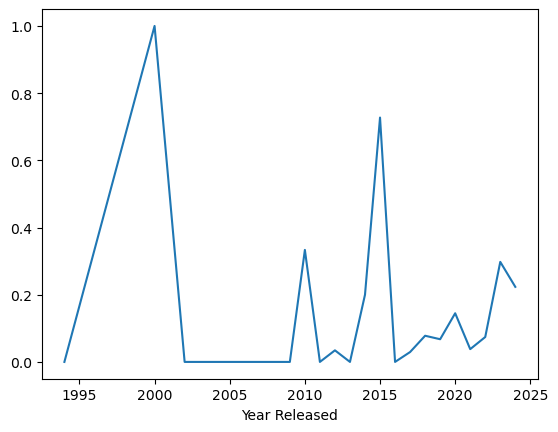

In [25]:
tmp.groupby('Year Released')['is_synthetic'].mean().plot()

<Axes: xlabel='Year Released'>

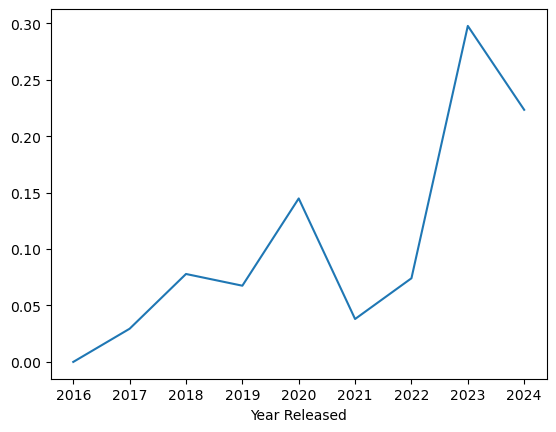

In [26]:
tmp.loc[tmp['Year Released'] >= 2016].groupby('Year Released')['is_synthetic'].mean().plot()

<Axes: xlabel='Year Released'>

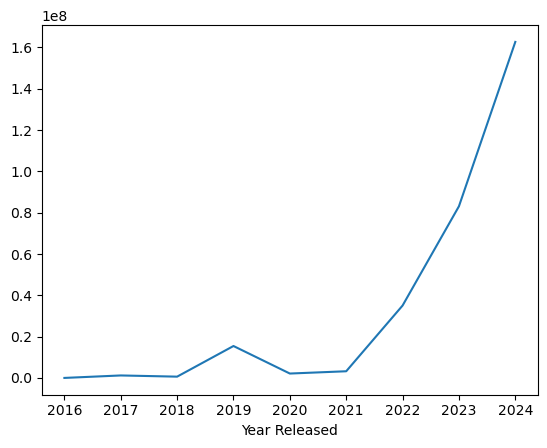

In [27]:
tmp_recent = tmp.loc[tmp['Year Released'] >= 2016].copy()
tmp_recent['synthetic_total_tokens'] = tmp_recent['is_synthetic'] * tmp_recent['Total Tokens']

tmp_recent.groupby('Year Released')['synthetic_total_tokens'].mean().plot()

In [28]:
# with pd.option_context('display.max_rows', None):
#     display(tmp.loc[tmp['Year Released'] == 2024, ['is_synthetic', 'Total Tokens', 'Dataset Name']].sort_values(['is_synthetic', 'Total Tokens'],
#                                                                                                         ascending=False))

<Axes: xlabel='Year Released'>

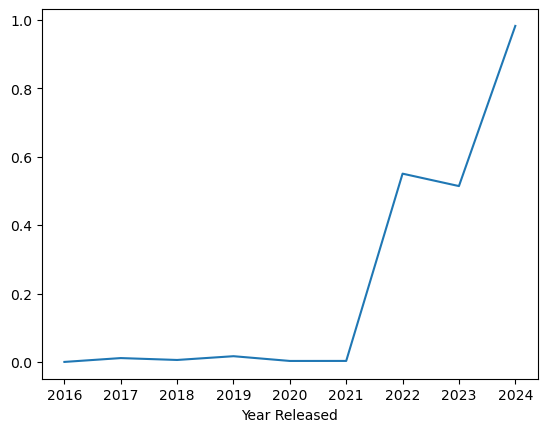

In [29]:
tmp_recent = tmp.loc[tmp['Year Released'] >= 2016].copy()
tmp_recent['synthetic_total_tokens'] = tmp_recent['is_synthetic'] * tmp_recent['Total Tokens']

ttt = tmp_recent.groupby('Year Released')['Total Tokens'].sum()
stt = tmp_recent.groupby('Year Released')['synthetic_total_tokens'].sum()

(stt / ttt).plot()

## Topics

In [30]:
tmp_t = tmp.copy()

gm_names = tmp_t['Task Groups'].apply(lambda s: list(set(s)) if not isinstance(s, float) else []).tolist()
gm_names = [y for x in gm_names for y in x]
gm_names = set(gm_names)

for name in gm_names:
    tmp_t['task_' + name] = tmp_t['Task Groups'].apply(lambda s: sum(v == name for v in s) if not isinstance(s, float) else np.nan)

tmp_t['num_sub_datasets'] = tmp_t['Task Groups'].apply(len)

tmp_t.drop('Task Groups', axis=1, inplace=True)

In [31]:
task_cols = [c for c in list(tmp_t) if c.startswith('task_')]

In [32]:
task_stats = tmp_t.groupby('is_synthetic')[task_cols].mean().T

task_stats

is_synthetic,False,True
task_Translation,1.179,0.292
task_Other,0.573,0.205
task_Generation,18.484,6.773
task_Creativity,9.318,2.848
task_Classification,28.362,14.355
task_Q&A,23.203,10.485
task_Summarization,4.445,1.842
task_Bias Detection,3.507,2.041
task_Reasoning,13.731,5.949
task_Code,7.494,1.176


In [33]:
tmp_tf = tmp_t.copy()
for c in task_cols:
    tmp_tf[c] = tmp_tf[c] / tmp_tf['num_sub_datasets']

task_stats_frac = tmp_tf.groupby('is_synthetic')[task_cols].mean().T

task_stats_frac

is_synthetic,False,True
task_Translation,0.022,0.010
task_Other,0.007,0.006
task_Generation,0.150,0.119
task_Creativity,0.058,0.058
task_Classification,0.249,0.219
task_Q&A,0.163,0.327
task_Summarization,0.056,0.038
task_Bias Detection,0.027,0.031
task_Reasoning,0.088,0.140
task_Code,0.175,0.042


In [34]:
def cos_sim(a, b):
    a /= np.linalg.norm(a)
    b /= np.linalg.norm(b)

    return np.dot(a, b)

In [35]:
cos_sim(task_stats[True], task_stats[False])

0.9855769006792909

In [36]:
cos_sim(task_stats_frac[True], task_stats_frac[False])

0.8645996200430868

## Languages

In [37]:
tmp['english_status'].value_counts()

english_status
english-only    2461
non-english      634
multilingual     401
Name: count, dtype: int64

In [38]:
est = tmp.groupby(['is_synthetic', 'english_status']).size().unstack(0)

est[True] / (est[False] + est[True])

english_status
english-only   0.126
multilingual   0.102
non-english    0.087
dtype: float64

In [39]:
est = tmp.groupby(['is_synthetic', 'english_status'])['Total Tokens'].sum().unstack(0)

est[True] / (est[False] + est[True])

english_status
english-only   0.335
multilingual   0.194
non-english    0.007
dtype: float64

In [40]:
tmp_recent = tmp.loc[tmp['Year Released'] >= 2016].copy()
tmp_recent['synthetic_total_tokens'] = tmp_recent['is_synthetic'] * tmp_recent['Total Tokens']

est = tmp_recent.groupby(['is_synthetic', 'english_status'])['Total Tokens'].sum().unstack(0)

est[True] / (est[False] + est[True])

english_status
english-only   0.339
multilingual   0.191
non-english    0.007
dtype: float64